In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

In [70]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, classification_report
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [71]:
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception:
    has_xgb = False
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("XGBoost available:", has_xgb)
print("Random State set to:", RANDOM_STATE)

XGBoost available: True
Random State set to: 42


In [72]:
def generate_synthetic_credit(n_samples=5000, random_state=RANDOM_STATE):
    rng = np.random.RandomState(random_state)
    age = rng.randint(18, 75, n_samples)
    income = np.round(rng.normal(45000, 20000, n_samples)).clip(5000, 250000)
    monthly_expenses = (income * rng.uniform(0.1, 0.6, n_samples)).astype(int)
    debt = np.round(rng.normal(6000, 8000, n_samples)).clip(0, 150000)
    num_open_loans = rng.poisson(1.2, n_samples).clip(0, 10)
    credit_history_years = np.round(rng.exponential(scale=6, size=n_samples)).astype(int).clip(0, 50)
    employment_status = rng.choice(
        ["employed", "self-employed", "unemployed"],
        size=n_samples, p=[0.75, 0.15, 0.10]
    )
    home_owner = rng.choice(
        ["owned", "mortgage", "rent"],
        size=n_samples, p=[0.4, 0.35, 0.25]
    )
    prev_defaults = rng.binomial(1, 0.08, n_samples)
    payment_history_score = (
        80
        + (income/10000)*2
        - prev_defaults*30
        - (debt/10000)*1.5
        + rng.normal(0, 10, n_samples)
    )
    payment_history_score = np.round(np.clip(payment_history_score, 0, 100))
    return pd.DataFrame({
        "age": age,
        "income": income,
        "monthly_expenses": monthly_expenses,
        "debt": debt,
        "num_open_loans": num_open_loans,
        "credit_history_years": credit_history_years,
        "employment_status": employment_status,
        "home_owner": home_owner,
        "prev_defaults": prev_defaults,
        "payment_history_score": payment_history_score
    })
df = generate_synthetic_credit(10)
print(df.head())


   age   income  monthly_expenses    debt  num_open_loans  \
0   56  76584.0             31087     0.0               1   
1   69  60349.0             10244  9006.0               1   
2   46  35611.0              8762  1195.0               6   
3   32  55851.0             15815  3666.0               0   
4   60  35732.0             11721  1186.0               0   

   credit_history_years employment_status home_owner  prev_defaults  \
0                    10          employed   mortgage              0   
1                     0          employed       rent              0   
2                    26          employed   mortgage              0   
3                     9     self-employed      owned              0   
4                     1          employed   mortgage              0   

   payment_history_score  
0                   87.0  
1                   98.0  
2                   85.0  
3                   86.0  
4                   92.0  


In [73]:
import numpy as np
import pandas as pd
n = 100
age = np.random.randint(21, 65, size=n)
income = np.random.randint(20000, 100000, size=n)
monthly_expenses = np.random.randint(5000, 50000, size=n)
debt = np.random.randint(0, 50000, size=n)
num_open_loans = np.random.randint(0, 10, size=n)
credit_history_years = np.random.randint(1, 20, size=n)
employment_status = np.random.choice(["employed", "unemployed", "self-employed"], size=n)
home_owner = np.random.choice(["yes", "no"], size=n)
prev_defaults = np.random.randint(0, 5, size=n)
payment_history_score = np.random.randint(300, 850, size=n)
df = pd.DataFrame({
    "age": age,
    "income": income,
    "monthly_expenses": monthly_expenses,
    "debt": debt,
    "num_open_loans": num_open_loans,
    "credit_history_years": credit_history_years,
    "employment_status": employment_status,
    "home_owner": home_owner,
    "prev_defaults": prev_defaults,
    "payment_history_score": payment_history_score
})
print(df.head())

   age  income  monthly_expenses   debt  num_open_loans  credit_history_years  \
0   59   32666             25666  17453               2                     4   
1   49   58660             49357  36212               0                    10   
2   35   23561             20708  43525               7                     5   
3   63   46854             31370  47202               2                     9   
4   28   84505              7811  32635               9                     3   

  employment_status home_owner  prev_defaults  payment_history_score  
0          employed         no              2                    649  
1          employed        yes              0                    745  
2          employed        yes              2                    649  
3     self-employed        yes              3                    436  
4          employed         no              3                    542  


In [74]:
logits = (
    -3.5
    + (df["debt"] / 10000) * 0.6
    - (df["income"] / 100000) * 2.0
    - (df["payment_history_score"] / 100) * 2.5
    + df["prev_defaults"] * 2.0
    - (df["credit_history_years"] / 10) * 0.4
    + (df["num_open_loans"] * 0.15)
    + np.where(df["employment_status"] == "unemployed", 0.8, 0.0)
    + np.where(df["home_owner"] == "rent", 0.3, 0.0)
    + np.random.normal(0, 0.5, len(df))
)
probs = 1 / (1 + np.exp(-logits))

In [75]:
def generate_synthetic_credit(n_samples=3000):
    rng = np.random.default_rng(42)
    age = rng.integers(21, 70, size=n_samples)
    income = rng.normal(50000, 15000, size=n_samples).clip(10000, 150000)
    monthly_expenses = rng.normal(2000, 800, size=n_samples).clip(500, 8000)
    debt = rng.normal(20000, 10000, size=n_samples).clip(0, 100000)
    num_open_loans = rng.integers(0, 10, size=n_samples)
    credit_history_years = rng.integers(0, 30, size=n_samples)
    employment_status = rng.choice(["employed", "unemployed", "self-employed"], size=n_samples, p=[0.7, 0.1, 0.2])
    home_owner = rng.choice(["own", "rent", "mortgage"], size=n_samples, p=[0.5, 0.3, 0.2])
    prev_defaults = rng.integers(0, 5, size=n_samples)
    payment_history_score = rng.normal(70, 20, size=n_samples).clip(0, 100)
    df = pd.DataFrame({
        "age": age,
        "income": income,
        "monthly_expenses": monthly_expenses,
        "debt": debt,
        "num_open_loans": num_open_loans,
        "credit_history_years": credit_history_years,
        "employment_status": employment_status,
        "home_owner": home_owner,
        "prev_defaults": prev_defaults,
        "payment_history_score": payment_history_score
    })
    logits = (
        -3.5
        + (df["debt"] / 10000) * 0.6
        - (df["income"] / 100000) * 2.0
        - (df["payment_history_score"] / 100) * 2.5
        + df["prev_defaults"] * 2.0
        - (df["credit_history_years"] / 10) * 0.4
        + (df["num_open_loans"] * 0.15)
        + np.where(df["employment_status"] == "unemployed", 0.8, 0.0)
        + np.where(df["home_owner"] == "rent", 0.3, 0.0)
        + rng.normal(0, 0.5, n_samples)
    )
    probs = 1 / (1 + np.exp(-logits))
    df["default"] = (rng.random(n_samples) < probs).astype(int)
    return df
df = generate_synthetic_credit(n_samples=3000)
print("Sample rows:")
print(df.head())
print("\nClass balance:")
print(df["default"].value_counts(normalize=True).round(3))

Sample rows:
   age        income  monthly_expenses          debt  num_open_loans  \
0   25  64444.408599       2305.352428  23509.129698               5   
1   58  39130.834227       1957.300124  18457.531726               6   
2   53  37193.611661       2869.060733  30492.683489               4   
3   42  56895.589325       1506.416397  12008.561670               6   
4   42  64828.298637       2788.939238  21201.609334               1   

   credit_history_years employment_status home_owner  prev_defaults  \
0                    14     self-employed       rent              4   
1                     9          employed       rent              1   
2                    11          employed        own              2   
3                     4          employed        own              4   
4                    21     self-employed        own              0   

   payment_history_score  default  
0              35.264973        1  
1              61.909036        0  
2              58.5

In [76]:
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
], remainder="passthrough")


In [77]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, class_weight="balanced_subsample"),
}
if has_xgb:
    models["XGBoost"] = XGBClassifier(n_estimators=300, use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE)

In [78]:
def evaluate_model(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    }
def plot_curves(y_true, y_proba, title=""):
    if y_proba is None:
        print("No probability scores for curves.")
        return
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true,y_proba):.3f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve " + title)
    plt.legend()
    plt.grid(True)
    plt.show()
    p, r, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(r, p)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve " + title)
    plt.grid(True)
    plt.show()
def run_models_pipeline(X, y, numeric_cols, cat_cols, models_dict, dataset_name="Credit"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
    results = []
    best_auc = -1
    best_pipeline = None
    for name, clf in models_dict.items():
        pipe = Pipeline([("pre", preprocessor), ("clf", clf)])
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        try:
            cv_auc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        except Exception:
            cv_auc = np.nan
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps["clf"], "predict_proba") else None
        metrics = evaluate_model(y_test, y_pred, y_proba)
        metrics["cv_auc"] = cv_auc
        metrics["model"] = name
        results.append(metrics)
        print(f"\n=== {dataset_name} | {name} ===")
        print(classification_report(y_test, y_pred, digits=4))
        ConfusionMatrixDisplay(confusion_matrix(confusion_matrix(y_test, y_pred))).plot()
        plt.title(f"Confusion Matrix ({dataset_name} - {name})")
        plt.show()
        plot_curves(y_test, y_proba, title=f"{dataset_name} - {name}")
        if not np.isnan(metrics["roc_auc"]) and metrics["roc_auc"] > best_auc:
            best_auc = metrics["roc_auc"]
            best_pipeline = pipe
    results_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
    return results_df, best_pipeline, (X_train, X_test, y_train, y_test)

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
def run_models_pipeline(X, y, numeric_cols, cat_cols, models, dataset_name="Dataset"):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    results = {}
    best_score = -1
    best_pipe = None
    for name, model in models.items():
        pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("clf", model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = acc
        if acc > best_score:
            best_score = acc
            best_pipe = pipe
    return results, best_pipe, (X_train, X_test, y_train, y_test)

In [81]:
X = df[feature_cols]
y = df["default"]
results, best_pipe, splits = run_models_pipeline(
    X, y, numeric_cols, cat_cols, models, dataset_name="Credit Scoring (Synthetic)"
)
print("\nSummary results:")
print(results)


Summary results:
{'LogisticRegression': 0.8366666666666667, 'RandomForest': 0.83, 'XGBoost': 0.795}



Top features (by importance / coefficient):
prev_defaults                      1.980116
employment_status_unemployed       0.675413
debt                               0.570842
payment_history_score              0.565443
num_open_loans                     0.444951
credit_history_years               0.364660
employment_status_self-employed    0.349936
employment_status_employed         0.325947
income                             0.309325
home_owner_own                     0.123652
home_owner_mortgage                0.116636
age                                0.080640
monthly_expenses                   0.063398
home_owner_rent                    0.006547
dtype: float64


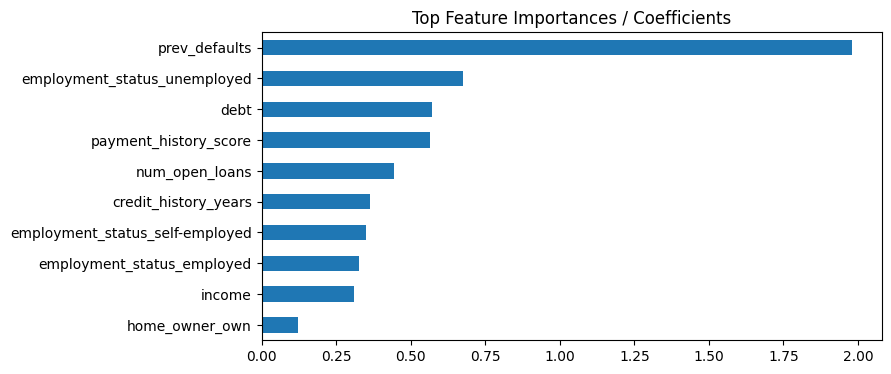

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
def get_tree_importances(pipe, feature_names):
    clf = pipe.named_steps["clf"]
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        return pd.Series(importances, index=feature_names).sort_values(ascending=False)
    if hasattr(clf, "coef_"):
        coefs = np.abs(clf.coef_).ravel()
        return pd.Series(coefs, index=feature_names).sort_values(ascending=False)
    return pd.Series(dtype=float)

if best_pipe is not None:
    try:
        feature_names = best_pipe.named_steps["preprocessor"].get_feature_names_out()
        clean_feature_names = [name.replace("num__", "")
                                   .replace("cat__", "")
                                   .replace("remainder__", "")
                               for name in feature_names]
        importances = get_tree_importances(best_pipe, clean_feature_names)
        print("\nTop features (by importance / coefficient):")
        print(importances.head(15))
        if not importances.empty:
            plt.figure(figsize=(8,4))
            importances.head(10).plot(kind="barh")
            plt.gca().invert_yaxis()
            plt.title("Top Feature Importances / Coefficients")
            plt.show()
    except Exception as e:
        print("Could not compute importances:", e)



Grid Search best params (RandomForest): {'clf__max_depth': 8, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Grid Search best CV ROC AUC: 0.9289175408581334
Test ROC AUC: 0.9134437891135023

Top features (RandomForest after GridSearch):
prev_defaults                      0.653320
payment_history_score              0.063135
debt                               0.061233
income                             0.046715
monthly_expenses                   0.040429
credit_history_years               0.039078
age                                0.035023
num_open_loans                     0.031751
employment_status_unemployed       0.006034
employment_status_employed         0.005693
home_owner_mortgage                0.004871
home_owner_rent                    0.004587
home_owner_own                     0.004515
employment_status_self-employed    0.003616
dtype: float64


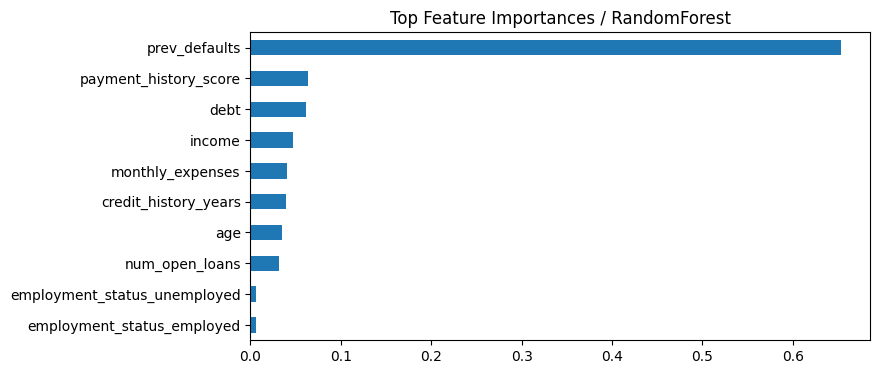

In [83]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced_subsample"))
])
param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 8, 12],
    "clf__min_samples_split": [2, 5]
}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(rf_pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)
grid.fit(splits[0], splits[2])
print("\nGrid Search best params (RandomForest):", grid.best_params_)
print("Grid Search best CV ROC AUC:", grid.best_score_)
best_pipe = grid.best_estimator_
y_pred = best_pipe.predict(splits[1])
if hasattr(best_pipe, "predict_proba"):
    y_proba = best_pipe.predict_proba(splits[1])[:,1]
    test_auc = roc_auc_score(splits[3], y_proba)
    print("Test ROC AUC:", test_auc)
def get_tree_importances(pipe, feature_names):
    clf = pipe.named_steps["clf"]
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        return pd.Series(importances, index=feature_names).sort_values(ascending=False)
    return pd.Series(dtype=float)
feature_names = best_pipe.named_steps["pre"].get_feature_names_out()
clean_feature_names = [name.replace("num__", "").replace("cat__", "").replace("remainder__", "") for name in feature_names]
importances = get_tree_importances(best_pipe, clean_feature_names)
print("\nTop features (RandomForest after GridSearch):")
print(importances.head(15))
if not importances.empty:
    plt.figure(figsize=(8,4))
    importances.head(10).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("Top Feature Importances / RandomForest")
    plt.show()


In [84]:
Path("exports").mkdir(exist_ok=True)
if best_pipe is not None:
    joblib.dump(best_pipe, "exports/credit_best_model.joblib")
    print("Saved best model to exports/credit_best_model.joblib")

Saved best model to exports/credit_best_model.joblib
